In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import re
import string
import os

In [3]:
cd ..

/data/nasif12/home_if12/chengju/project/news


In [4]:
fkn = pd.read_pickle("./data/fkn_back.gzip")

In [5]:
title = fkn["title"].apply(lambda x: " ".join(x))
texts = fkn["text"].apply(lambda x: " ".join(x))
labels = fkn['label']

## word to index

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [7]:
# To turn,  maximum number of top words to consider (sorted by freq)
MAX_NB_WORDS = 50000

In [8]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [9]:
artical_len = [len(sq) for sq in sequences]
[i for i, j in enumerate(artical_len) if j == max(artical_len)] 

[4733]

(array([  5.99400000e+03,   2.78000000e+02,   4.30000000e+01,
          1.50000000e+01,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([     0. ,   1163.5,   2327. ,   3490.5,   4654. ,   5817.5,
          6981. ,   8144.5,   9308. ,  10471.5,  11635. ]),
 <a list of 10 Patch objects>)

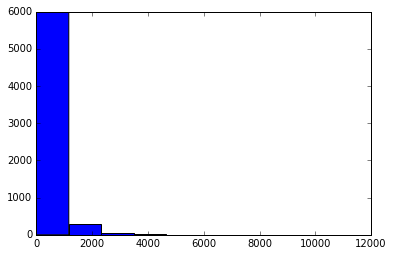

In [10]:
plt.hist(artical_len)

In [11]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 78439 unique tokens.


In [12]:
# maximum sequence length of an artical, shorter ones are padded with 0 at the beginning
# longer ones take the last MAX_SEQUENCE_LENGTH ones
MAX_SEQUENCE_LENGTH = 2000

In [13]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [14]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (6335, 2000)
Shape of label tensor: (6335, 2)


In [15]:
VALIDATION_SPLIT = 0.2

In [16]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [17]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

## Embedding

In [18]:
embeddings_index = {}
f = open('./data/GloVe/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [19]:
EMBEDDING_DIM = 50

In [20]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [21]:
embedding_matrix.shape

(78440, 50)

In [22]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

## Train networks

In [23]:
## required keras modules
from keras.models import Model, load_model
import keras.layers as kl
import keras.optimizers as ko
from keras import backend as k 
from keras import regularizers
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
import keras.callbacks as kc

In [85]:
sequence_input = kl.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = kl.Conv1D(64, 3, activation='relu',
             kernel_regularizer=regularizers.l2(0.01))(embedded_sequences)
x = kl.MaxPooling1D(pool_size=2)(x)  # global max pooling
x = kl.BatchNormalization()(x)
x = kl.Bidirectional(kl.LSTM(50, recurrent_regularizer=regularizers.l2(0.01)))(x)
#x = kl.Dropout(0.2)(x)
preds = kl.Dense(2, activation='sigmoid')(x)

In [86]:
model.compile(loss='binary_crossentropy', 
              optimizer=ko.RMSprop(lr=0.0001), 
              metrics=['acc'])

In [87]:
model.fit(x_train, y_train, 
          validation_split=.2,
          epochs=200, 
          batch_size=128,
          callbacks=[kc.EarlyStopping(patience=2)])

Train on 4054 samples, validate on 1014 samples
Epoch 1/200
4054/4054 [==============================] - 51s - loss: 0.0861 - acc: 0.9715 - val_loss: 0.2739 - val_acc: 0.9107
Epoch 2/200
4054/4054 [==============================] - 48s - loss: 0.0841 - acc: 0.9740 - val_loss: 0.2824 - val_acc: 0.9048
Epoch 3/200
4054/4054 [==============================] - 49s - loss: 0.0794 - acc: 0.9761 - val_loss: 0.2908 - val_acc: 0.9088
Epoch 4/200
4054/4054 [==============================] - 49s - loss: 0.0792 - acc: 0.9761 - val_loss: 0.2694 - val_acc: 0.9127
Epoch 5/200
4054/4054 [==============================] - 49s - loss: 0.0775 - acc: 0.9766 - val_loss: 0.2873 - val_acc: 0.8989
Epoch 6/200
4054/4054 [==============================] - 49s - loss: 0.0803 - acc: 0.9742 - val_loss: 0.2716 - val_acc: 0.9117
Epoch 7/200
4054/4054 [==============================] - 49s - loss: 0.0769 - acc: 0.9776 - val_loss: 0.2697 - val_acc: 0.9191


In [88]:
# model.save("./data/models/LSTM")
model.save("./data/models/CNN_LSTM1")

In [89]:
history = model.history.history

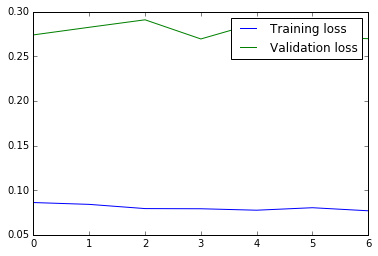

In [91]:
plt.plot(history['loss'], label="Training loss")
plt.plot(history['val_loss'], label="Validation loss")
plt.legend(loc="upper right")